# Markowitz's Theory and Uncertainty?

## Remark

This is as difficult an exercise as I can imagine setting - it requires you to really think about the finance. If your group made any progress
on this question, that's fantastic. I did not expect an answer as sophisticated as my model answer.

## Markowitz's model 

In Markowitz's model of portfolio selection it is assumed that you can invest in $n$ assets whose
returns over the investment period have a known covariance matrix $\Sigma$ and mean $\bm{\mu}$.

Markowitz's theory then says that if you wish to achieve a desired return $R$ you should invest
in a portfolio whose weights in each asset are given by a vector $\bm{w}$. This vector of weights
should be chosen to be the solution of the optimization problem

$$\underset{\bm{w}\in\R^n}{\text{minimize}} = \bm{w}^\top \Sigma \bm{w} $$

subject to:

$$\bm{w}^\top \boldsymbol{1} = 1$$
$$\bm{w}^\top \boldsymbol{\mu} = R.$$

This problem can easily be solved using a quadratic optimizer.

## Uncertainty

Markowitz's model assumes that you somehow know the covariance matrix $\Sigma$ and the mean $\mu$, but
how would you actually know these values in the first place?

Markowitz's theory does not attempt to answer this question itself. One answer you might suggest
is to assume that the mean and covariance matrix of the returns for the assets is constant over time
and estimate them from historic data.

But even if it were true that that the returns are normally distributed, we can only estimate
the mean and covariance matrix, so this will introduce some inaccuracy.

## Example

We computed the mean and covariance of the 75 stocks which remained in the FTSE 100 from 2000 to 2014. The
mean weekly return and standard deviation of weekly returns is plotted below. We will use this example in all
our computations in this presentation.

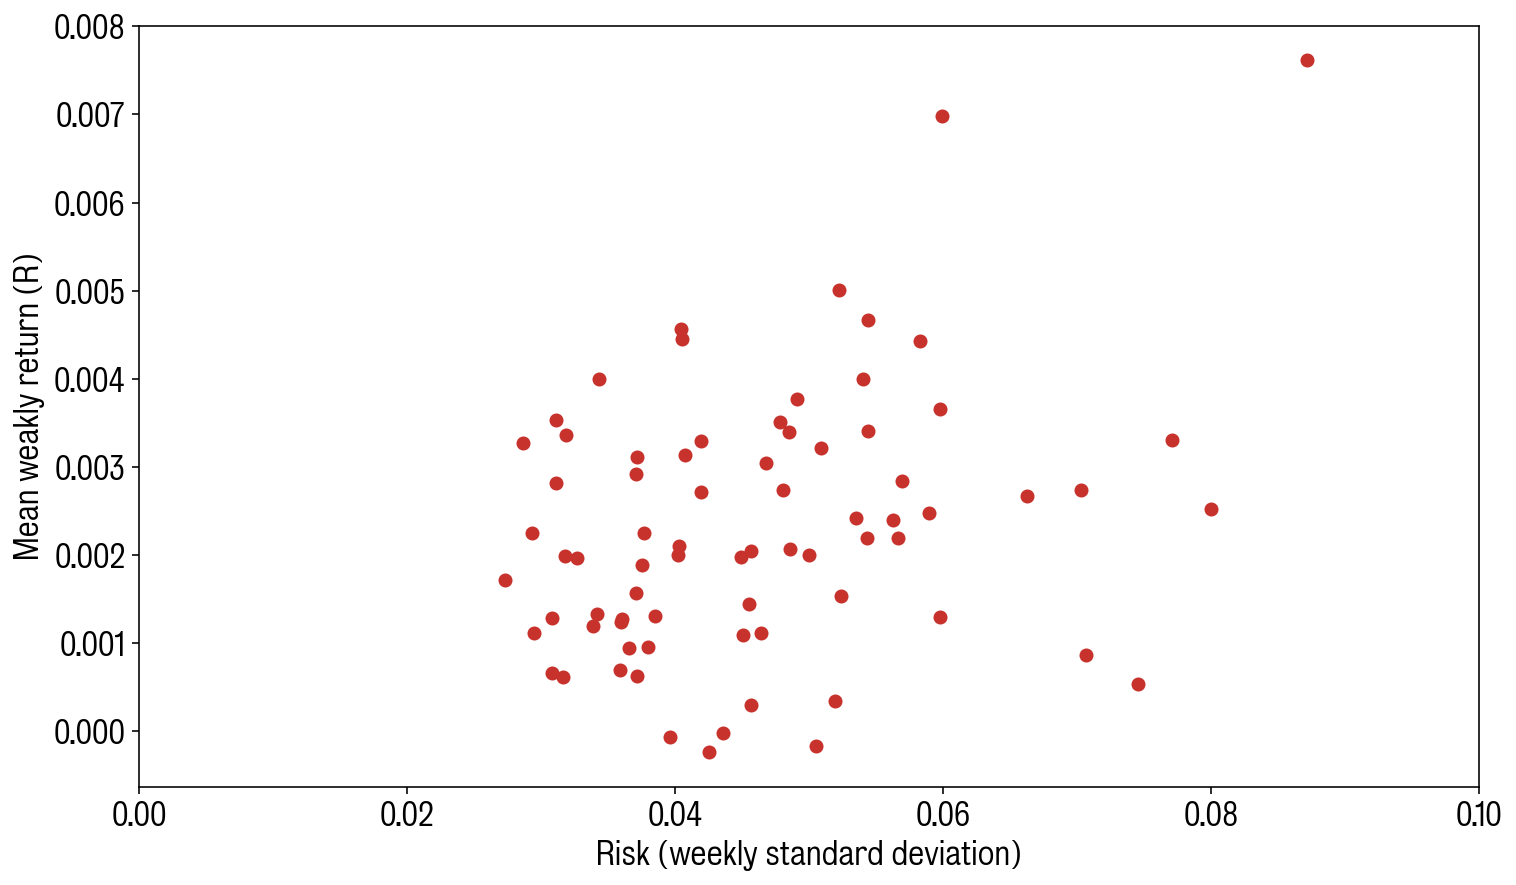

In [1]:
## No slide

from markowitzlib import *
import matplotlib.pyplot as plt

return_history = read_return_history()
mu = np.mean( return_history, axis = 0)
sigma = np.cov( return_history, rowvar = False )

def plot_stock_points( sigma, mu):
    num_stocks = len(mu)
    sds = np.zeros( num_stocks )
    for i in range(0,num_stocks):
        sds[i] = sqrt(sigma[i,i])

    ax = plt.gca()
    ax.scatter(sds,mu)
    ax.set_xlabel('Risk (weekly standard deviation)')
    ax.set_ylabel('Mean weakly return (R)');
    ax.set_xlim(0,0.1)

plot_stock_points(sigma, mu)

## The impact of uncertainty

To evaluate the impact of uncertainty, we will consider a market where we **assume** that
the weekly asset returns are normally distributed with mean $\bm{\mu}$ and covariance matrix $\Sigma$.
We will consider an investor who wants to achieve a return of $R=0.003$ by investing for one week.

We will repeat the following experiment `n_repeats` times. Let the index $i$ denote the $i$-th repeat.

* Generate our own sample of $N$ sets of returns from the multivariate normal distribution
  $\bm{\mu}$ and covariance matrix $\Sigma$.
* Compute the covariance marix $\Sigma^\prime_i$ and mean $\bm{\mu}^\prime_i$ from this sample
* Solve the Markowitz problem for a market with mean return $\bm{\mu}^\prime_i$ and covariance matrix $\Sigma^\prime_i$
  with desired return $R=0.003$ to find an optimal set of weights $\bm{w}_i$
* Simulate a single instance of the returns actually achieved if one invests with weights $\bm{w}_i$
* Store the under the name $r_i$

The end result will be a vector $r$ containing the actual returns achieved. We may then compare
the mean and the standard deviation of the vector $r$ with the expected return $R=0.003$.

## A mental image

* You can think of $\mu$ and $\Sigma$ as the covariance matrix and return somehow known by a god.
* $\mu^\prime_i$ and $\Sigma^\prime_i$ are the covariance matrix and return measured by a trader based on $N$ days data.
* Each repeat of the experiment takes place in a parallel universe. The label $i$ refers to the covariance, mean returns,
weights and actual final return in that universe.

## How we perform this experiment in detail

* To simulate the multivariate normal distribution we compute the Cholesky decomposition $L$ of $\Sigma$, that
  is the unique lower triangular matrix with positive diagonal satisfying $L L^\top = \Sigma$. We may then
  simulate a vector $\boldsymbol{\epsilon}$ of $n$ independent standard normal random random variables. 
  $L \boldsymbol{\epsilon}$ will then have the desired distribution.
    
* We solve the Markowitz problem using the `cxvopt` package. It would be possible to use the analytic solution of the Markowitz problem
  if so desired

## Results with 100 repeats

We have plotted the result of our experiment in the case where `n_repeats=100` below.


In [1]:
def simulate_multivariate_normal(sigma, mu,  n_samples ):
    n = len(mu)
    L = np.linalg.cholesky( sigma )
    samples = L @ np.random.randn(n,n_samples)
    return samples.transpose()+mu

def simulate_measure_then_invest( sigma, mu, R, N, n_repeats ):
    r = np.zeros(n_repeats)
    for i in range(0,n_repeats):
        simulated_history = simulate_multivariate_normal(sigma, mu,  N )
        mu_prime_i = np.mean( simulated_history, axis=0 )
        sigma_prime_i = np.cov( simulated_history, rowvar=False )
        soln = solve_markowitz( sigma_prime_i, mu_prime_i, R )
        w_i = np.array( soln['weights'] );
        actual_returns = simulate_multivariate_normal(sigma, mu,  1 )
        r[i] = actual_returns @ w_i
    return r

R = 0.003
res = solve_markowitz(sigma, mu, R )
naive_sd = res['sd']
n_repeats = 100 # Should be 100, reduce the value to get the notebook to run faster.

n_plt_points = 8
n_days_history = np.zeros(n_plt_points)
mean_in_practice = np.zeros(n_plt_points)
sd_in_practice = np.zeros(n_plt_points)

for j in range(0,n_plt_points):
    n_days = (j+1) * 100
    n_days_history[j] = n_days
    print('Computing with {} weeks'.format(n_days))
    r = simulate_measure_then_invest(
        sigma, mu, R, n_days, n_repeats)
    mean_in_practice[j] = np.mean(r)
    sd_in_practice[j] = np.std( r )

NameError: name 'solve_markowitz' is not defined

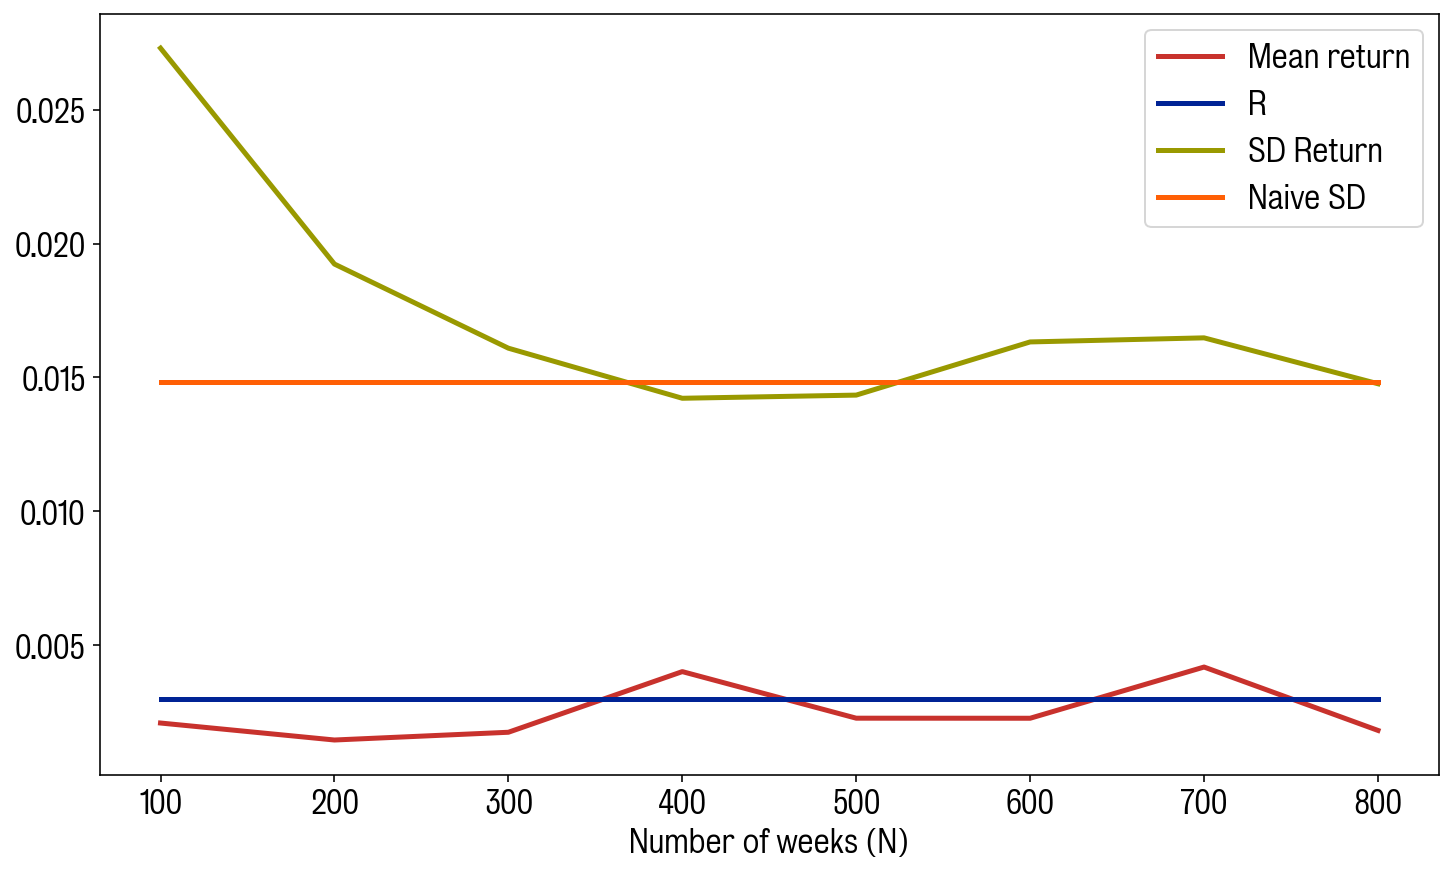

In [3]:
# No slide
plt.plot( n_days_history, mean_in_practice, label='Mean return')
plt.plot( n_days_history, R*np.ones(n_plt_points), label='R' )
plt.plot( n_days_history, sd_in_practice, label='SD Return' )
plt.plot( n_days_history, naive_sd*np.ones(n_plt_points), label='Naive SD' )
ax = plt.gca()
ax.set_xlabel('Number of weeks (N)')
plt.legend();

## How accurate do we need to be?


This is a judgement call.

Let's say that the result is acceptable if the expected return is within $1\%$ of the actual expected return and
the standard deviation of the return is within $1\%$.

Physicists may perform experiment with an accuracy of one part in a million, but in finance less accuracy is required.

## How many repeats do we need to perform?

The plot of the mean return against the number of weeks is very wobbly. This is because we only perform
the experiment 100 times. By the central limit theorem we expect this to be approximately normally
distributed with standard deviation

$$ \frac{\sigma}{\sqrt {\tt{n\_repeats}}}$$

where $\sigma$ is the standard deviation of the return, which is about $0.015$

To achieve an accuracy of about $1\%$ we will need to choose $\tt{n\_repeats}$ so that

$$
\frac{0.015}{\sqrt {\tt{n\_repeats}}} < 0.01 \times  R
$$

So

$$
\tt{n\_repeats}>250000
$$

This will be quite slow, so can we be more clever? The answer is yes, we can actually compute the mean return for the experiment in universe `i` analytically. This gets
rid of a lot of the random noise in our computation.

In [4]:
# No slide
def simulate_measure_then_invest( true_sigma, true_mu, R, n_days_data, n_repeats ):
    a = np.zeros(n_repeats)
    b = np.zeros(n_repeats)
    for i in range(0,n_repeats):
        simulated_history = simulate_multivariate_normal(true_sigma, true_mu,  n_days_data )
        measured_mu = np.mean( simulated_history, axis=0 )
        measured_sigma = np.cov( simulated_history, rowvar=False )
        soln = solve_markowitz(measured_sigma, measured_mu, R )
        w = np.array( soln['weights'] );
        a[i] = true_mu @ w
        b[i] = w.transpose() @ true_sigma @ w + a[i]**2
    return a, b

n_plt_points = 8
n_days_history = np.zeros(n_plt_points)
expected_return = np.zeros(n_plt_points)
sd = np.zeros(n_plt_points)
mean_std = np.zeros(n_plt_points)

for j in range(0,n_plt_points):
    n_days = (j+1) * 100
    n_days_history[j] = n_days
    print('Computing with {} weeks'.format(n_days))
    a, b = simulate_measure_then_invest(
        sigma, mu, R, n_days, n_repeats)
    expected_return[j] = np.mean(a)
    sd[j] = np.sqrt(np.mean(b) - expected_return[j]**2)
    mean_std[j] = np.std( a )

Computing with 100 weeks


Computing with 200 weeks


Computing with 300 weeks


Computing with 400 weeks


Computing with 500 weeks


Computing with 600 weeks


Computing with 700 weeks


Computing with 800 weeks


## Outcome of the more efficient experiment

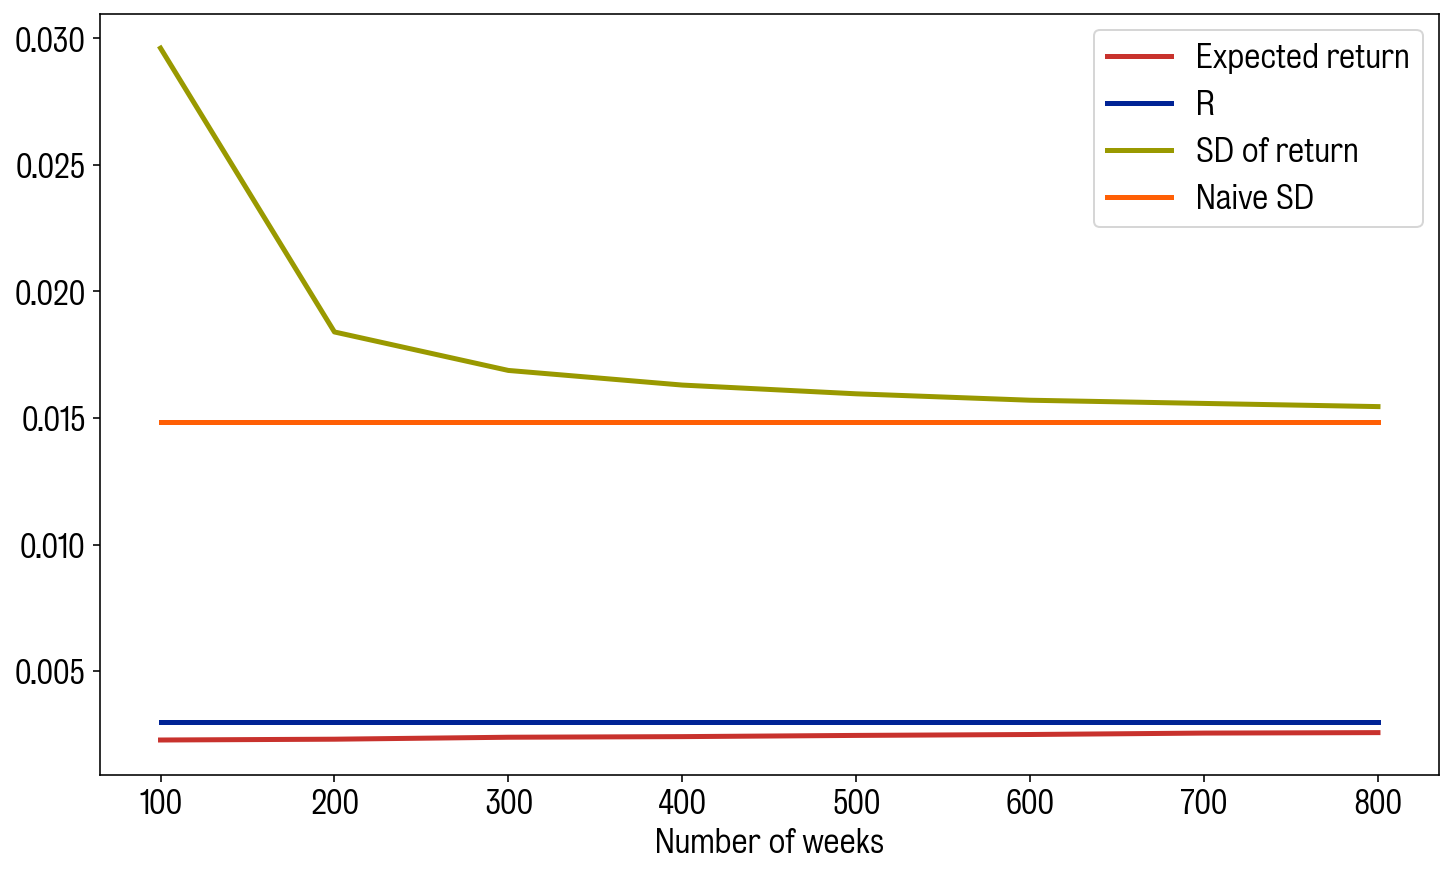

In [5]:
# No slide
plt.plot( n_days_history, expected_return, label='Expected return')
plt.plot( n_days_history, R*np.ones(n_plt_points), label='R' )
plt.plot( n_days_history, sd, label='SD of return' )
plt.plot( n_days_history, naive_sd*np.ones(n_plt_points), label='Naive SD' )
plt.legend();
plt.gca().set_xlabel('Number of weeks');

## Improving the plot

Rather than plot the expected return it is more informative to plot the relative error of the return.
We can define this as

$$
\text{Relative Error of Return}=\left| \frac{Expected Return - R}{R}\right|
$$

Similarly, plotting the relative error of the standard deviation achieved compared to the naive standard
deviation will be more informative.

Another detail that will give us a better chart will be to use logarithmic axes. This will allow us
to identify an error of order $1%$ which is too small to be seen visually using normal axes.

Since we are using logarithmic axes, we should use exponentially spaced plot points along the x-axis.
So whereas the number of days was taken to be $(j+1) \times 100$ in the previous plots, we'll take it
to be given by $2^j \times 100$ in our logarithmic plot

## A log-log plot of the relative error

In [6]:
mean_std = np.zeros(n_plt_points)
for j in range(0,n_plt_points):
    n_days = (2**j) * 100
    n_days_history[j] = n_days
    print('Computing with {} weeks '.format(n_days))
    a, b = simulate_measure_then_invest(
        sigma, mu, R, n_days, n_repeats)
    expected_return[j] = np.mean(a)
    sd[j] = np.sqrt(np.mean(b) - expected_return[j]**2)
    mean_std[j] = np.std( a )

Computing with 100 weeks 


Computing with 200 weeks 


Computing with 400 weeks 


Computing with 800 weeks 


Computing with 1600 weeks 


Computing with 3200 weeks 


Computing with 6400 weeks 


Computing with 12800 weeks 


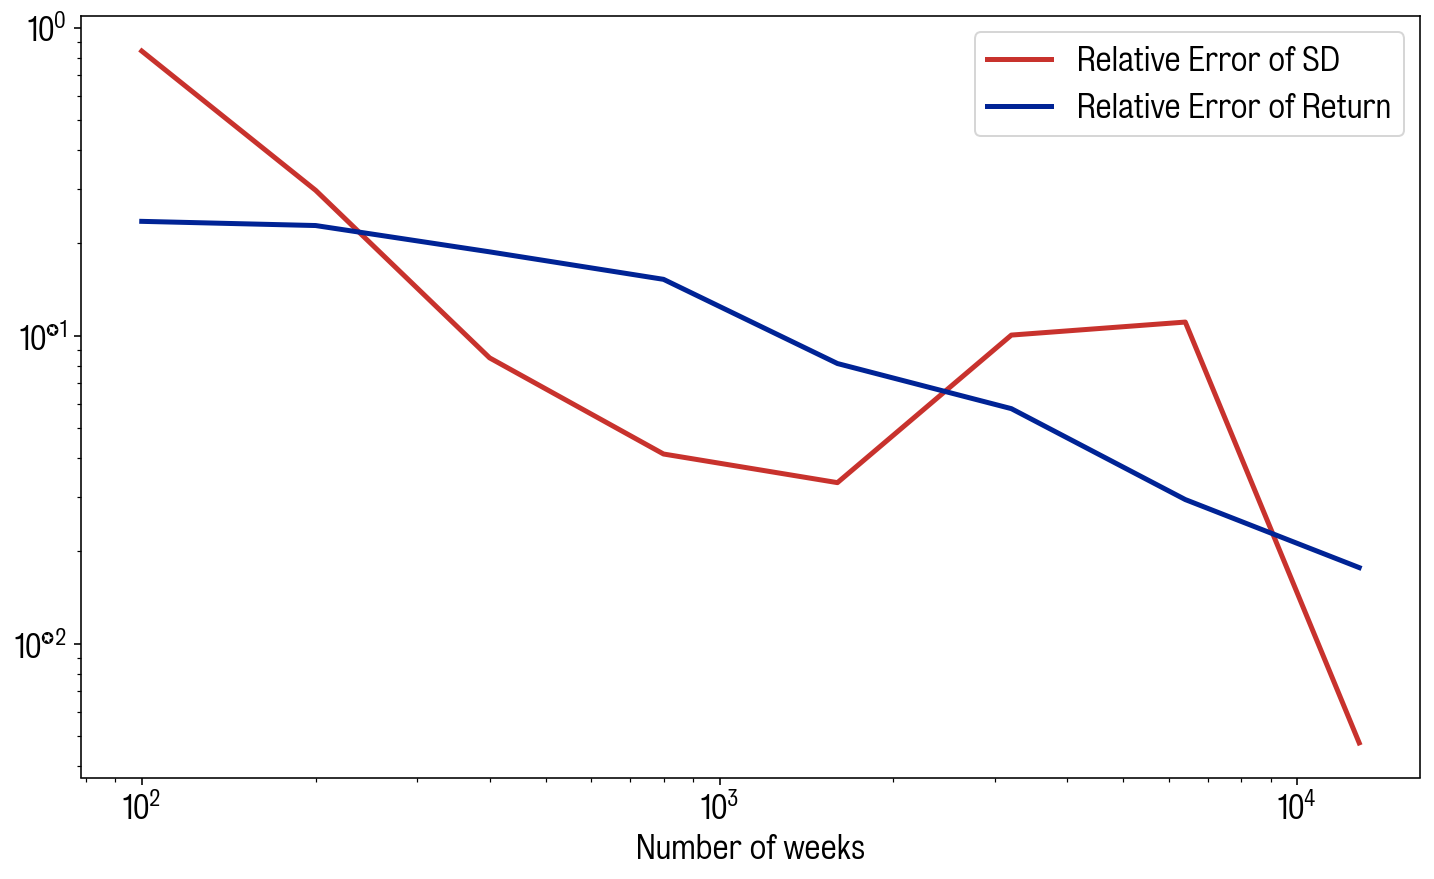

In [7]:
# No slide
relative_error_mean = (np.abs(expected_return - R))/R
relative_error_sd = (np.abs(sd_in_practice-naive_sd))/naive_sd
plt.plot( n_days_history, relative_error_sd, label='Relative Error of SD' );
plt.plot( n_days_history, relative_error_mean, label='Relative Error of Return' );
plt.legend()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of weeks');

## Including the error bars

The vector $\bm{a}$ contains samples of the value of the expected return that is achieved in each experiment.

We are using the mean of $\bm{a}$ as an estimate of the overall expected return across all experiments, so we can
compute an estimate for the error in our overall expected return using the central limit theorem.


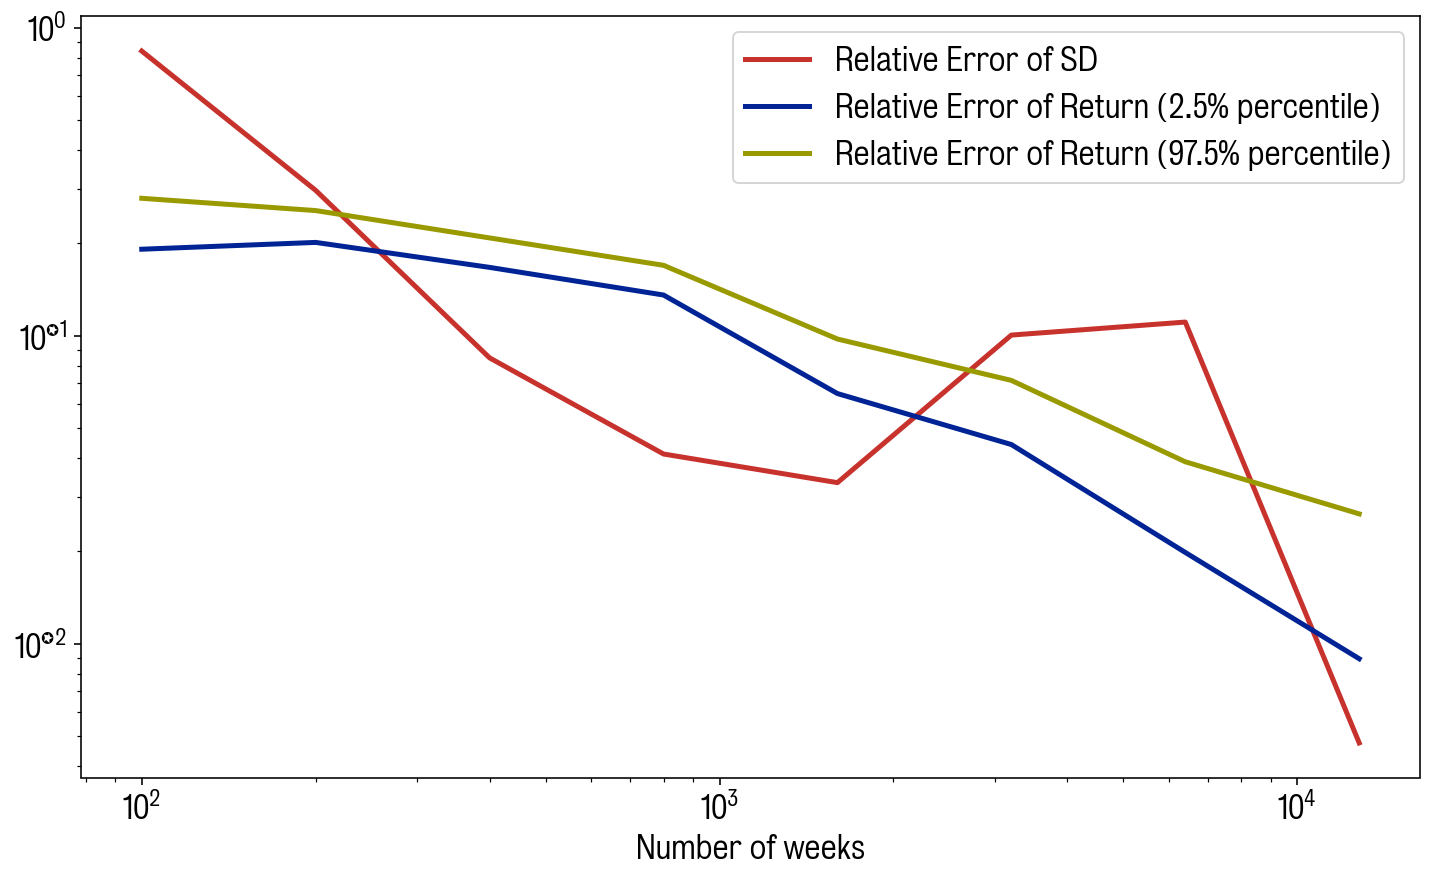

In [8]:
# No slide
confidence_upper = expected_return + 1.96*mean_std/sqrt(n_repeats)
confidence_lower = expected_return - 1.96*mean_std/sqrt(n_repeats)
relative_error_upper = np.abs( confidence_upper - R)/R
relative_error_lower = np.abs( confidence_lower - R)/R
plt.plot( n_days_history, relative_error_sd, label='Relative Error of SD' );
plt.plot( n_days_history, relative_error_upper, label='Relative Error of Return (2.5% percentile)' );
plt.plot( n_days_history, relative_error_lower, label='Relative Error of Return (97.5% percentile)' );
plt.legend()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of weeks');

## Conclusion

Our plots indicate that we do not achieve the desired accuracy even if we use a sample containing $10^4$ weeks data. That's 192 years of data.

It isn't really plausible that there is any group of assets whose values have followed a normal distribution with a constant mean and covariance
matrix for the last 192 years.

The problem is caused in part because our statistical model contains approximately $\frac{75^2}{2}\approx 5600$ parameters, so we need
a lot of data to estimate the model.

This does not mean the Markowitz model is useless, just that it must be used with caution! It is certainly a powerful theoretical tool that shows the importance of diversification.